In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import random

In [11]:
# Importing the test and train data (20/80 split), and the full dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
full_data = pd.read_csv('cleaned_data/diabetes_cleaned.csv')

# Removing the first column
train = train.iloc[:, 1:]
test = test.iloc[:, 1:]
full_data = full_data.iloc[:, 1:]

In [13]:
# Following the method used in KEH_LTW modeling notebook to create a train dataset 
# that has an equal distribution of (0) and (1) response
# 1. Determine the observations with (1) response. Let this be n observations.
#   MODIFICATION: pull the (1) response from the full dataset to increase the number of observations
# 2. Randomly sample n observations with (0) response, and combine in a new train dataset with (1) response observations.
# 3. Randomly shuffle the new train dataset

admitted = full_data.loc[full_data.readmitted == 1, :]
n = admitted.shape[0]

not_readmitted = full_data.loc[full_data.readmitted == 0, :].sample(n)

train1 = pd.concat([admitted, not_readmitted])
train1 = train1.sample(frac = 1)

In [15]:
train1.readmitted.value_counts()

1    6293
0    6293
Name: readmitted, dtype: int64

#### Summary of KEH LTW Modeling

Variables that have a relationship with `readmitted`, from full dataset EDA:
- `age`: as age increases, the proportion of individuals readmitted to the hospital increases. The number of observations overall increases. This trend persists until age 75, after which the number of hospital visits drop and the proportion of readmitted : not readmitted evens out. This variable is already binned by nature of our original dataset.
    - -> because different age ranges have different distributions of readmitted : not readmitted, look into making each age bin its own predictor, if this isn't happening already
- `time_in_hospital`: as time in hospital increases, the number of observations increase (up until 3 days), and then start to decrease. The ratio of readmitted : not readmitted gradually increases as `time_in_hospital` increases.
    - -> the different distribution of readmittied: not readmitted at for each value of `time_in_hospital`. Similarly, look into making each day bin its own predictor, if it isn't already
- `num_of_changes`: there doesn't seem to be much difference 
- `number_inpatient`: large difference!

Interactions
- as `age` increases, the `time_in_hospital` increases
- as `time_in_hospital` increases, the `um_of_changes` also increases

Models
1. `readmitted ~ time_in_hospital*age + num_of_changes + number_inpatient`
2. `readmitted ~ num_of_changes*time_in_hospital + number_inpatient + age`
3. `readmitted ~ num_of_changes*time_in_hospital + age*time_in_hospital + number_inpatient`

Thoughts
- More variable selection
    - diag_1, diag_2, diag_3
    - num_medications
    - num_lab_procedures
- Make the bins in `age` and `time_in_hospital` their own predictors
- Evaluate performance of the existing KEH-LTW models with k-fold cross-validation
- Look to see if there are other interactions or transformations

Text(0.5, 0, 'age')

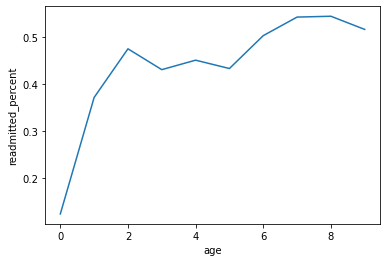

In [47]:
#Re-creating the plot of diabetes_percent vs age created earlier, just to check if the function binned age correctly. Yes, it did.
age_data = train1.groupby('age')['readmitted'].agg([('readmitted_percent','mean'),('nobs','count')]).reset_index(drop=False)
sns.lineplot(x = age_data.index, y= age_data['readmitted_percent'])
plt.xlabel('age')

Text(0.5, 0, 'time_in_hospital')

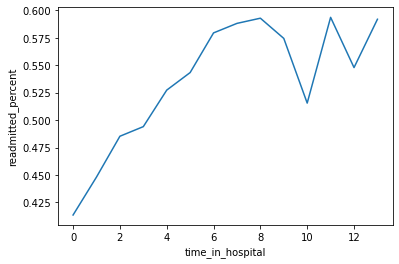

In [48]:
#Re-creating the plot of diabetes_percent vs age created earlier, just to check if the function binned age correctly. Yes, it did.
time_data = train1.groupby('time_in_hospital')['readmitted'].agg([('readmitted_percent','mean'),('nobs','count')]).reset_index(drop=False)
sns.lineplot(x = time_data.index, y= time_data['readmitted_percent'])
plt.xlabel('time_in_hospital')

#### KEH_LTW function for calculating confusion matrix and other evaluation statistics

In [22]:
from sklearn.metrics import roc_curve, auc

#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

#### Inspecting the existing models

Model 1: `readmitted ~ time_in_hospital*age + num_of_changes + number_inpatient`

In [16]:

logit_model = sm.logit(formula = 'readmitted ~ time_in_hospital*age + num_of_changes + number_inpatient', data = train1).fit() #Developing logistic regression model
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.676824
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                12586
Model:                          Logit   Df Residuals:                    12580
Method:                           MLE   Df Model:                            5
Date:                Wed, 22 Feb 2023   Pseudo R-squ.:                 0.02355
Time:                        09:52:40   Log-Likelihood:                -8518.5
converged:                       True   LL-Null:                       -8724.0
Covariance Type:            nonrobust   LLR p-value:                 1.339e-86
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.1322      0.143     -7.919      0.000      -1.412      -0.852
time_in_hospital         0.0723      0.029      2.535      0.011       0.016       0.128
age                      0.0114      0.002      5.386      0.000       0.007       0.016
time_in_hospital:age    -0.0003      0.000     -0.717      0.473      -0.001       0.001
num_of_changes           0.1864      0.039      4.839      0.000       0.111       0.262
number_inpatient         0.3554      0.028     12.776      0.000       0.301       0.410
========================================================================================
"""

-8518.50984265179

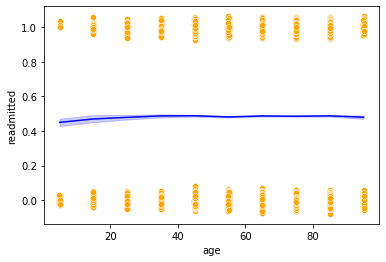

In [19]:
# Question: Can we visualize the logistic model in a multidimensional space, to account for all parameters used in the model?

def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)

sns.scatterplot(x = jitter(train1.age,0), y = jitter(train1.readmitted,0), data = train1, color = 'orange')
sns.lineplot(x = 'age', y= logit_model.predict(train), data = train1, color = 'blue') 
logit_model.llf



Classification accuracy = 57.3%
Precision = 58.3%
TPR or Recall = 51.2%
FNR = 48.8%
FPR = 36.6%
ROC-AUC = 60.1%


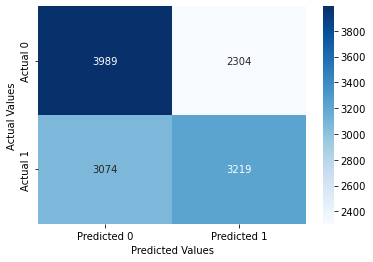

In [42]:
confusion_matrix_data(train1,train1.readmitted,logit_model,cutoff=0.5)

Classification accuracy = 61.9%
Precision = 12.2%
TPR or Recall = 51.2%
FNR = 48.8%
FPR = 37.0%
ROC-AUC = 60.1%


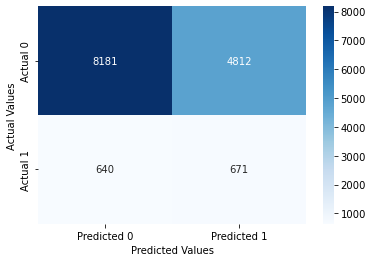

In [43]:
confusion_matrix_data(test,test.readmitted,logit_model,cutoff=0.5)

In [ ]:
# cross validation


Model 1.1 -- Making each age group its own predictor

In [53]:
# try making age a dummy variable
age_dummy = pd.get_dummies(train1.age)
age_dummy.columns = ["age5", "age15", "age25", "age35", "age45", "age55", "age65", "age75", "age85", "age95"]
age_dummy

train1_with_age_dummy = pd.concat([train1, age_dummy], axis=1)
train1_with_age_dummy

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,age5,age15,age25,age35,age45,age55,age65,age75,age85,age95
547,4575066,1601532,AfricanAmerican,Male,15,5,18,7,2,?,...,0,1,0,0,0,0,0,0,0,0
15692,72639354,23426973,AfricanAmerican,Female,75,5,2,9,3,?,...,0,0,0,0,0,0,0,1,0,0
54406,221551482,14359797,Caucasian,Male,65,1,1,1,5,MC,...,0,0,0,0,0,0,1,0,0,0
58054,247034214,40970709,Caucasian,Male,75,1,2,7,4,SP,...,0,0,0,0,0,0,0,1,0,0
40510,156171708,85748535,Caucasian,Female,75,1,1,1,2,MC,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62301,277612920,58118616,Caucasian,Female,85,1,1,7,2,CM,...,0,0,0,0,0,0,0,0,1,0
24317,102882612,23449869,AfricanAmerican,Female,65,1,1,7,1,?,...,0,0,0,0,0,0,1,0,0,0
48702,181848708,42849963,Caucasian,Female,65,1,1,7,9,SP,...,0,0,0,0,0,0,1,0,0,0
23624,100810050,8192781,AfricanAmerican,Female,45,1,1,4,5,MD,...,0,0,0,0,1,0,0,0,0,0


In [56]:
'time_in_hospital +' + '+'.join(list(age_dummy.columns))

'time_in_hospitalage5+age15+age25+age35+age45+age55+age65+age75+age85+age95'

In [57]:
logit_model_age_dummy = sm.logit(formula = 'readmitted ~ ' + '+'.join(list(age_dummy.columns)), data = train1_with_age_dummy).fit() 
logit_model_age_dummy.summary()

Optimization terminated successfully.
         Current function value: 0.688495
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                12586
Model:                          Logit   Df Residuals:                    12575
Method:                           MLE   Df Model:                           10
Date:                Wed, 22 Feb 2023   Pseudo R-squ.:                0.006711
Time:                        10:34:06   Log-Likelihood:                -8665.4
converged:                       True   LL-Null:                       -8724.0
Covariance Type:            nonrobust   LLR p-value:                 1.958e-20
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2653        nan        nan        nan         nan         nan
age5          -1.6807        nan        nan        nan         nan         nan
age15         -0.2608        nan        nan        nan         nan         nan
age25          0.1623        nan        nan        nan         nan         nan
age35         -0.0158        nan        nan        nan         nan         nan
age45          0.0657        nan        nan        nan         nan         nan
age55         -0.0061        nan        nan        nan         nan         nan
age65          0.2738        nan        nan        nan         nan         nan
age75          0.4313        nan        nan        nan         nan         nan
age85          0.4385        nan        nan        nan         nan         nan
age95          0.3266        nan        nan        nan         nan         nan
==============================================================================
"""

Classification accuracy = 53.9%
Precision = 52.8%
TPR or Recall = 73.2%
FNR = 26.8%
FPR = 65.4%
ROC-AUC = 55.0%


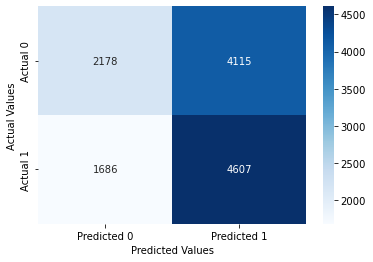

In [64]:
confusion_matrix_data(train1_with_age_dummy,train1_with_age_dummy.readmitted,logit_model_age_dummy,cutoff=0.5)

In [59]:
age_dummy_test = pd.get_dummies(test.age)
age_dummy_test.columns = ["age5", "age15", "age25", "age35", "age45", "age55", "age65", "age75", "age85", "age95"]
age_dummy_test

test_with_age_dummy = pd.concat([test, age_dummy_test], axis=1)
test_with_age_dummy

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,age5,age15,age25,age35,age45,age55,age65,age75,age85,age95
0,146959422,23921190,Caucasian,Male,75,1,1,1,1,MC,...,0,0,0,0,0,0,0,1,0,0
1,269313870,68564790,Caucasian,Female,65,1,2,7,10,SI,...,0,0,0,0,0,0,1,0,0,0
2,97960512,942255,Caucasian,Female,85,1,1,9,2,MC,...,0,0,0,0,0,0,0,0,1,0
3,150690678,23300775,Caucasian,Female,85,1,2,7,5,MC,...,0,0,0,0,0,0,0,0,1,0
4,95896962,63993240,Caucasian,Female,35,3,1,1,2,CP,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14299,25115496,6766083,Caucasian,Female,65,1,2,7,3,?,...,0,0,0,0,0,0,1,0,0,0
14300,44139738,1090485,AfricanAmerican,Male,55,1,1,7,2,?,...,0,0,0,0,0,1,0,0,0,0
14301,270107010,43862292,Caucasian,Male,75,3,1,1,3,BC,...,0,0,0,0,0,0,0,1,0,0
14302,194509800,92745000,Caucasian,Male,65,1,2,7,13,MC,...,0,0,0,0,0,0,1,0,0,0


Classification accuracy = 37.8%
Precision = 10.0%
TPR or Recall = 72.7%
FNR = 27.3%
FPR = 65.7%
ROC-AUC = 54.2%


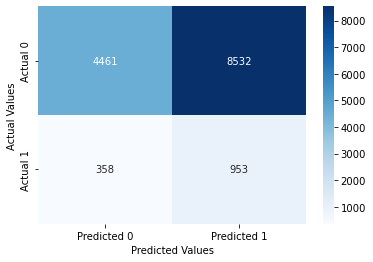

In [60]:
confusion_matrix_data(test_with_age_dummy,test_with_age_dummy.readmitted,logit_model_age_dummy,cutoff=0.5)

Quick observations
- The classification accuracy for the test data decreased compared to the train data, suggesting overfitting.
- Precision decreased --> among the classified positives, not many are true positives
- This trend is reflected in the highest false positive rate
- ROC-AUC went down

But now the model is classifying datapoints as positive!

In [ ]:
# try adding the other terms of the model, and all possible interactions between time_in_hospital and the age predictors
# logit_model_age_dummy = sm.logit(formula = 'readmitted ~ time_in_hospital*age + num_of_changes + number_inpatient', data = train1_with_age_dummy).fit() #Developing logistic regression model

Model 2: `readmitted ~ num_of_changes*time_in_hospital + number_inpatient + age`

Model 3: `readmitted ~ num_of_changes*time_in_hospital + age*time_in_hospital + number_inpatient`